In [1]:
import os
import requests
import zipfile
from tqdm.notebook import tqdm

url = "https://data.nasa.gov/docs/legacy/ai4mars-dataset-merged-0.1.zip"
zip_path = "ai4mars-dataset.zip"
extract_dir = "ai4mars-dataset"

# Download with progress bar
def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as f, tqdm(
        desc=dest_path,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            size = f.write(chunk)
            bar.update(size)

# Download if not already done
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    download_file(url, zip_path)
else:
    print("ZIP file already downloaded.")

# Unzip
if not os.path.exists(extract_dir):
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Done.")
else:
    print("Dataset already extracted.")


ai4mars-dataset.zip:   0%|          | 0.00/5.72G [00:00<?, ?iB/s]

Extracting...
Done.


In [2]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
walk_through(extract_dir)

There are 1 directories and 0 images in 'ai4mars-dataset'.
There are 2 directories and 1 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1'.
There are 2 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl'.
There are 3 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/images'.
There are 0 directories and 18130 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/images/edr'.
There are 0 directories and 18096 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/images/rng-30m'.
There are 0 directories and 18097 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/images/mxy'.
There are 2 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels'.
There are 0 directories and 16064 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/train'.
There are 3 directories and 0 images in 'ai4mars-dataset/ai4mars-dataset-merged-0.1/msl/labels/test'.
There are 0 directories and 322 images in '

In [4]:
import os
import shutil
import random
from tqdm.notebook import tqdm

# Input paths
root_dir = "ai4mars-dataset/ai4mars-dataset-merged-0.1/msl"
images_dir = os.path.join(root_dir, "images", "edr")
labels_dir = os.path.join(root_dir, "labels", "train")

# Output paths
subset_dir = "ai4mars-subset"
subset_images = os.path.join(subset_dir, "images")
subset_labels = os.path.join(subset_dir, "labels")

# Make output dirs
os.makedirs(subset_images, exist_ok=True)
os.makedirs(subset_labels, exist_ok=True)

# Build base filename sets
image_dict = {f.rsplit(".", 1)[0]: f for f in os.listdir(images_dir) if f.lower().endswith(".jpg")}
label_dict = {f.rsplit(".", 1)[0]: f for f in os.listdir(labels_dir) if f.lower().endswith(".png")}

# Intersection of base names
common_basenames = sorted(set(image_dict.keys()) & set(label_dict.keys()))
print(f"✅ Found {len(common_basenames)} matched image-label pairs.")

# Select up to 5000
subset_size = min(5000, len(common_basenames))
subset_basenames = random.sample(common_basenames, subset_size)

# Copy matched files
print(f"📦 Copying {subset_size} pairs to 'ai4mars-subset/'...")
for base in tqdm(subset_basenames):
    shutil.copy(os.path.join(images_dir, image_dict[base]), os.path.join(subset_images, image_dict[base]))
    shutil.copy(os.path.join(labels_dir, label_dict[base]), os.path.join(subset_labels, label_dict[base]))

print("✅ Subset creation complete!")


✅ Found 16064 matched image-label pairs.
📦 Copying 5000 pairs to 'ai4mars-subset/'...


  0%|          | 0/5000 [00:00<?, ?it/s]

✅ Subset creation complete!


In [5]:
walk_through(subset_dir)

There are 2 directories and 0 images in 'ai4mars-subset'.
There are 0 directories and 5000 images in 'ai4mars-subset/images'.
There are 0 directories and 5000 images in 'ai4mars-subset/labels'.


In [98]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.ndimage import distance_transform_edt
from collections import deque
import cv2
from PIL import Image
import torch
import torchvision
import glob

In [87]:
IMG_SIZE = 256
TERRAIN_COSTS = {
    0: 1,    # soil
    1: 4,    # bedrock
    2: 6,    # sand
    3: 10,   # big rock
    255: 100 # unlabeled (high cost)
}

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [38]:
def load_model(model_path="deeplabv3_mars.pth"):
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)
    model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, 4)

    # Load full checkpoint
    state_dict = torch.load(model_path, map_location=device)

    # Filter out aux_classifier keys
    filtered_dict = {k: v for k, v in state_dict.items() if not k.startswith("aux_classifier")}

    model.load_state_dict(filtered_dict, strict=False)

    model.to(device)
    model.eval()
    return model


In [58]:
def draw_mask(mask, title="Predicted Mask"):
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()


In [39]:
def predict_mask(model, image_path):
    transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        mask = output.argmax(1).squeeze().cpu().numpy()

    return mask


In [92]:
def draw_path_on_original(image_path, mask, path):
    img = Image.open(image_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    img_np = np.array(img)

    # Draw path with gradient (blue to red)
    for i in range(1, len(path)):
        # Color changes from green (start) to red (goal)
        r = int(255 * i/len(path))
        g = int(255 * (1 - i/len(path)))
        b = 0

        # Draw thicker line for main path
        cv2.line(img_np, (path[i-1][1], path[i-1][0]),
                 (path[i][1], path[i][0]), (r, g, b), 3)

        # Draw thinner highlight
        cv2.line(img_np, (path[i-1][1], path[i-1][0]),
                 (path[i][1], path[i][0]), (255, 255, 255), 1)

    # Mark start (green) and end (red) points
    cv2.circle(img_np, (path[0][1], path[0][0]), 10, (0, 255, 0), -1)
    cv2.circle(img_np, (path[-1][1], path[-1][0]), 10, (255, 0, 0), -1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)
    plt.title("Optimized Rover Path (Red=Start, Green=Goal)")
    plt.axis("off")
    plt.show()


In [80]:
def find_optimal_start_goal(cost_map):
    """Finds points near edges with lowest terrain cost"""
    height, width = cost_map.shape
    border = 20  # Distance from edge

    # Left edge (start candidates)
    left_col = cost_map[border:-border, border]
    start_y = np.argmin(left_col) + border

    # Right edge (goal candidates)
    right_col = cost_map[border:-border, -border]
    goal_y = np.argmin(right_col) + border

    return (start_y, border), (goal_y, width-border)

In [88]:

def convert_to_cost_map(mask):
    cost_map = np.zeros_like(mask, dtype=np.float32)
    for cls, cost in TERRAIN_COSTS.items():
        cost_map[mask == cls] = cost
    return cost_map

In [89]:

def find_valid_point(cost_map, start_point, max_cost=10):
    """Find nearest point with cost <= max_cost using BFS"""
    h, w = cost_map.shape
    queue = deque([start_point])
    visited = set([start_point])

    while queue:
        y, x = queue.popleft()
        if cost_map[y, x] <= max_cost:
            return (y, x)
        for dy, dx in [(0,1), (0,-1), (1,0), (-1,0)]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w and (ny, nx) not in visited:
                visited.add((ny, nx))
                queue.append((ny, nx))
    return start_point  # Fallback


In [90]:
def build_graph(cost_map):
    """Create graph with edge weights based on terrain cost"""
    h, w = cost_map.shape
    G = nx.grid_2d_graph(h, w)

    # Remove nodes in completely impassable terrain
    for node in list(G.nodes):
        if cost_map[node] >= 100:  # Unpassable terrain
            G.remove_node(node)

    # Add edge weights
    for u, v in G.edges():
        cost = (cost_map[u] + cost_map[v]) / 2
        G.edges[u, v]['weight'] = cost

    return G


In [91]:
def compute_path(cost_map, start, goal):
    """Compute path using A* algorithm with terrain awareness"""
    # Create traversability map (1 where cost < 20)
    traversable = (cost_map < 20).astype(np.float32)

    # Calculate distance to obstacles
    obstacle_dist = distance_transform_edt(traversable)

    # Create graph with cost + distance penalty
    adjusted_cost = cost_map + 20/(obstacle_dist + 1)

    # Build graph with adjusted costs
    G = build_graph(adjusted_cost)

    # Verify start/goal are in graph
    if start not in G or goal not in G:
        return []

    try:
        return nx.astar_path(G, start, goal, weight='weight')
    except:
        return []


In [64]:
def draw_path(mask, path):
    vis = np.stack([mask]*3, axis=-1) * 60
    for y, x in path:
        vis[y, x] = [255, 0, 0]  # red path
    plt.figure(figsize=(6, 6))
    plt.imshow(vis)
    plt.title("Planned Rover Path")
    plt.axis("off")
    plt.show()

In [93]:
def plan_rover_path(image_path, model):
    mask = predict_mask(model, image_path)
    cost_map = convert_to_cost_map(mask)

    # Find valid start/goal points
    start = find_valid_point(cost_map, (50, 50))
    goal = find_valid_point(cost_map, (200, 200))

    path = compute_path(cost_map, start, goal)

    if not path:
        print("⚠️ No valid path found - consider adjusting terrain costs")
        # Show cost map for debugging
        plt.figure(figsize=(10, 10))
        plt.imshow(cost_map, cmap='viridis')
        plt.colorbar(label='Terrain Cost')
        plt.title("Terrain Cost Map (No Path Found)")
        plt.axis("off")
        plt.show()
    else:
        print(f"✅ Path found with {len(path)} steps")
        draw_path_on_original(image_path, mask, path)

In [94]:
model = load_model("deeplabv3_mars.pth")

✅ Path found with 301 steps


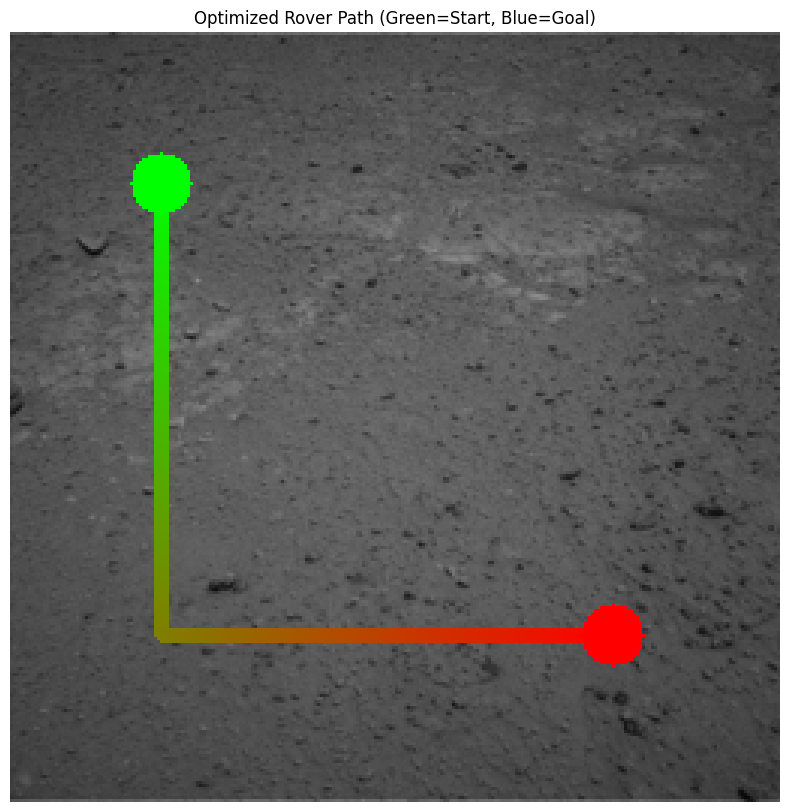

✅ Path found with 301 steps


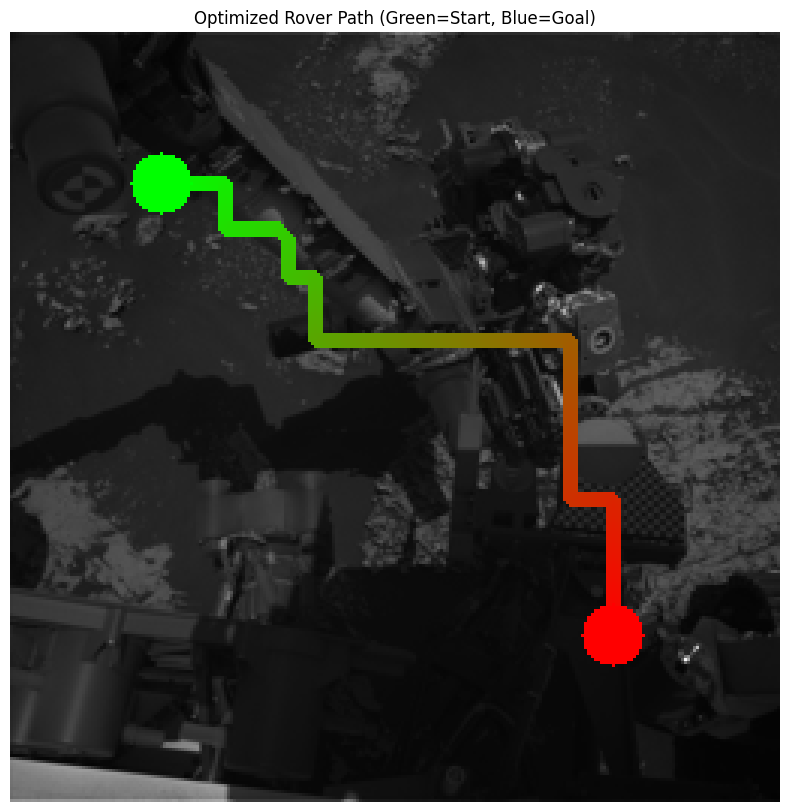

✅ Path found with 349 steps


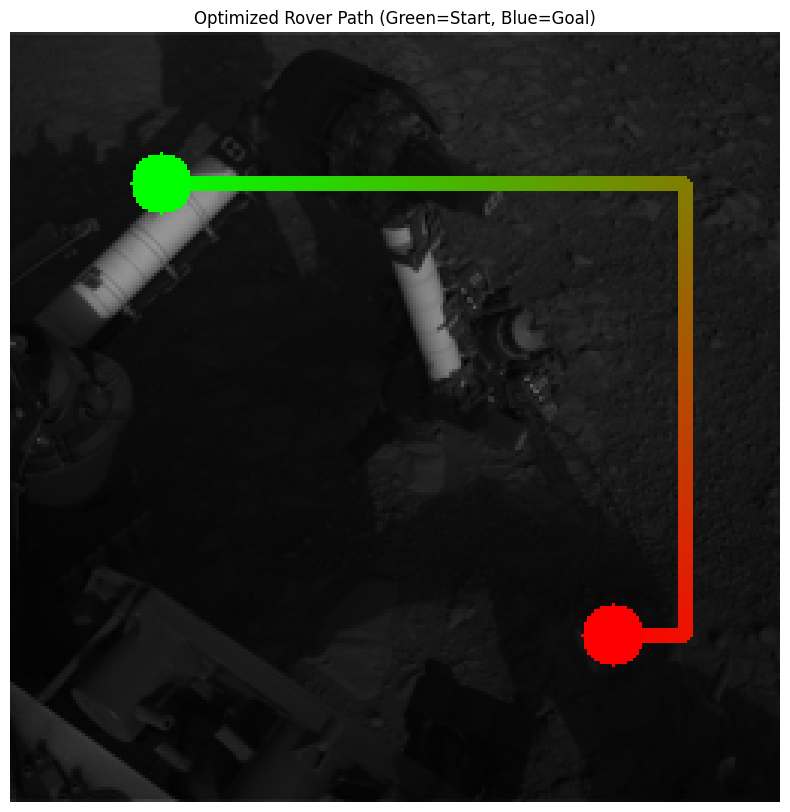

✅ Path found with 301 steps


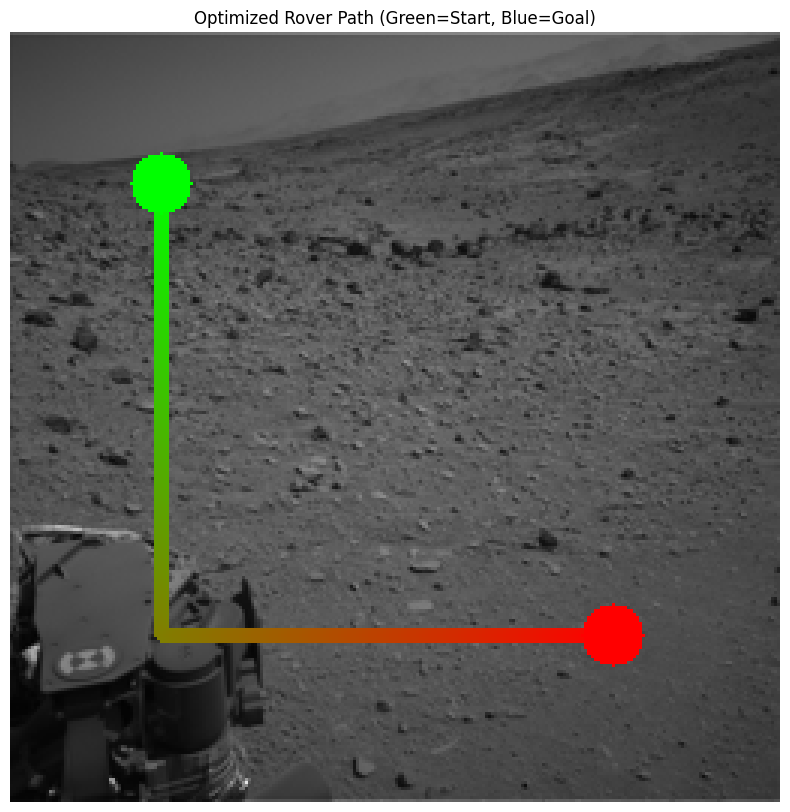

✅ Path found with 305 steps


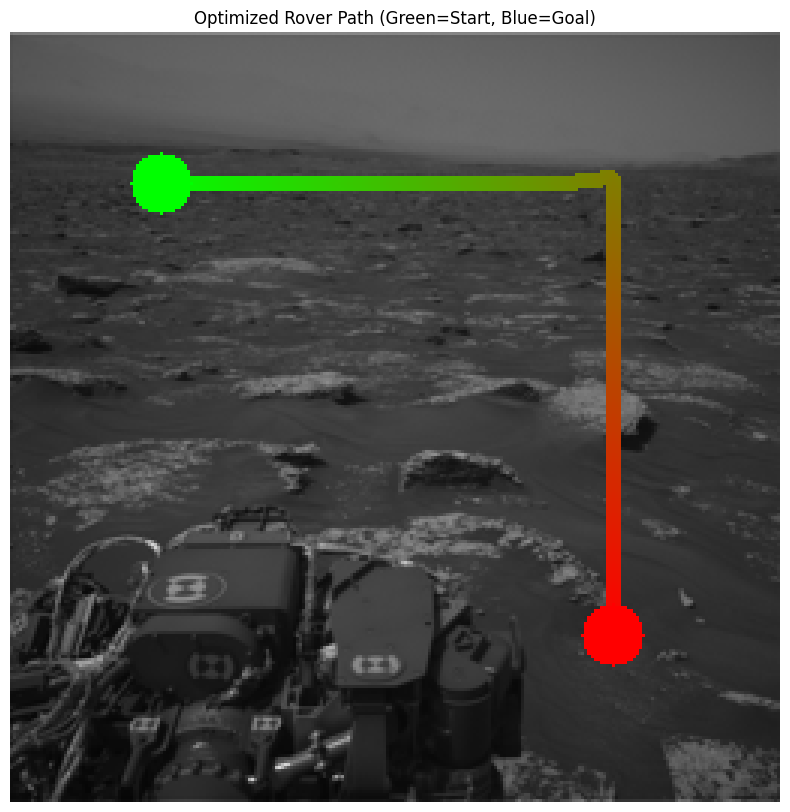

In [100]:
import random
import glob

# Get all images
image_files = glob.glob("/content/ai4mars-subset/images/*.JPG")
num_images = len(image_files)

# Randomly pick 5 unique indices
picked_indices = set()
while len(picked_indices) < 5:
    picked_indices.add(random.randint(0, num_images - 1))

# Use the selected images
for idx in picked_indices:
    img_path = image_files[idx]
    plan_rover_path(img_path, model)
